# Crash Course on Fast EDA using Chat GPT
## this documents step by step explanation on prompt engeneering with GPT 
### by AMBADY

In [128]:
# Keeps stapce for explantions


In [129]:
#Kepp Space for Imports
import pandas as pd
import sqlite3, urllib.request, tempfile
import numpy as np
import matplotlib.pyplot as plt

In [130]:
# Get youe data source
url = "https://techassessment.blob.core.windows.net/aiap20-group-exercise-data/call_duration_modified.db"

In [131]:
# download to a temp file
import sqlite3
import pandas as pd
from pathlib import Path

DB_PATH = Path("./data/call_duration_modified.db")

# --- 1) List table names -----------------------------------------------------
with sqlite3.connect(DB_PATH) as conn:
    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' "
        "ORDER BY name;",
        conn,
    )["name"].tolist()

print("Tables found:", tables)

# --- 2) Open each table and load into a pandas DataFrame ----------------------
dfs = {}
with sqlite3.connect(DB_PATH) as conn:
    for t in tables:
        dfs[t] = pd.read_sql(f'SELECT * FROM "{t}";', conn)

# Example: access one table
# df = dfs["<your_table_name>"]

# --- 3) List column names and types for each table ---------------------------
schemas = {}
with sqlite3.connect(DB_PATH) as conn:
    for t in tables:
        schema_df = pd.read_sql(f'PRAGMA table_info("{t}");', conn)
        # schema_df has columns: cid, name, type, notnull, dflt_value, pk
        schemas[t] = schema_df[["name", "type"]]

        print(f"\n=== {t} : Columns & Types ===")
        print(schemas[t])

# --- 4) Show statistics (transpose) ------------------------------------------
for t, df in dfs.items():
    print(f"\n=== {t} : describe().T ===")
    # include='all' to get stats for non-numeric columns too
    stats = df.describe(include="all").transpose()
    print(stats)


Tables found: ['call_duration_modified']

=== call_duration_modified : Columns & Types ===
                          name     type
0                           SN  INTEGER
1                          Age  INTEGER
2                   Occupation     TEXT
3        Previous Contact Days  INTEGER
4  Previous Number of Contacts  INTEGER
5             Previous Outcome     TEXT
6               Campaign Calls  INTEGER
7       Campaign Call Duration  INTEGER
8          Subscription Status     TEXT

=== call_duration_modified : describe().T ===
                               count unique          top   freq        mean  \
SN                           41188.0    NaN          NaN    NaN     20594.5   
Age                          41188.0    NaN          NaN    NaN    40.02406   
Occupation                     41188     12       admin.  10422         NaN   
Previous Contact Days        41188.0    NaN          NaN    NaN  962.475454   
Previous Number of Contacts  41188.0    NaN          NaN    NaN    

In [132]:
categorical_cols = ["Occupation", "Previous Outcome", "Subscription Status"]
regression_cols  = ["Age",
                    "Previous Contact Days",
                    "Previous Number of Contacts",
                    "Campaign Calls",
                    "Campaign Call Duration"]

In [133]:
categorical_cols = ["Occupation", "Previous Outcome", "Subscription Status"]
regression_cols  = [
    "Age",
    "Previous Contact Days",
    "Previous Number of Contacts",
    "Campaign Calls",
    "Campaign Call Duration",
]
id_cols = ["SN"]

print("Categorical:", categorical_cols)
print("Regression :", regression_cols)
print("ID-like    :", id_cols)

Categorical: ['Occupation', 'Previous Outcome', 'Subscription Status']
Regression : ['Age', 'Previous Contact Days', 'Previous Number of Contacts', 'Campaign Calls', 'Campaign Call Duration']
ID-like    : ['SN']


In [134]:
df = df.drop(columns=["SN"], errors="ignore")

In [135]:
df.head()

,Age,Occupation,Previous Contact Days,Previous Number of Contacts,Previous Outcome,Campaign Calls,Campaign Call Duration,Subscription Status
0,56,housemaid,999,0,nonexistent,1,261,no
1,57,services,999,0,nonexistent,1,149,no
2,37,services,999,0,nonexistent,1,226,no
3,40,admin.,999,0,nonexistent,1,151,no
4,56,services,999,0,nonexistent,1,307,no


In [136]:
categorical_cols = ["Occupation", "Previous Outcome", "Subscription Status"]

# 1) Dict of uniques (works fine)
unique_vals = {c: df[c].dropna().unique().tolist() for c in categorical_cols}

# 2) Value counts per column
for c in categorical_cols:
    print(f"\n=== {c} ===")
    print(df[c].value_counts(dropna=False))

# 3) Long-form DataFrame of uniques  ✅ FIXED
rows = []
for c in categorical_cols:
    for v in df[c].dropna().unique():
        rows.append((c, v))
uniques_long = pd.DataFrame(rows, columns=["column", "value"])
print(uniques_long.head())



=== Occupation ===
Occupation
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

=== Previous Outcome ===
Previous Outcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

=== Subscription Status ===
Subscription Status
no     36548
yes     4640
Name: count, dtype: int64
       column        value
0  Occupation    housemaid
1  Occupation     services
2  Occupation       admin.
3  Occupation  blue-collar
4  Occupation   technician


In [137]:
# Cell 1: Unique values per column
import pandas as pd

# assuming df already exists
unique_vals = {col: df[col].dropna().unique().tolist() for col in df.columns}

# Pretty print
for col, vals in unique_vals.items():
    print(f"\n=== {col} ({len(vals)} unique) ===")
    


=== Age (78 unique) ===

=== Occupation (12 unique) ===

=== Previous Contact Days (27 unique) ===

=== Previous Number of Contacts (8 unique) ===

=== Previous Outcome (3 unique) ===

=== Campaign Calls (42 unique) ===

=== Campaign Call Duration (1544 unique) ===

=== Subscription Status (2 unique) ===


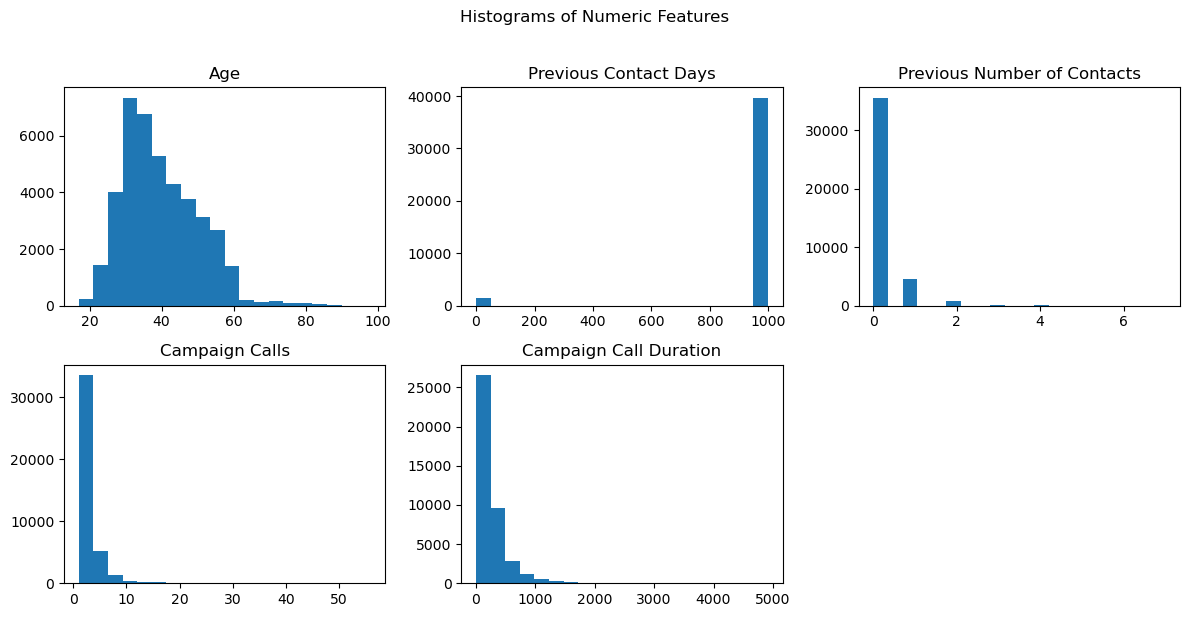

In [138]:
# Cell 2
import math
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include="number").columns.tolist()

if not num_cols:
    print("No numeric columns to plot.")
else:
    n = len(num_cols)
    n_cols = 3                           # how many subplots across
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.ravel()

    for i, col in enumerate(num_cols):
        axes[i].hist(df[col].dropna(), bins=20)
        axes[i].set_title(col)

    # remove extra axes if any
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    fig.suptitle("Histograms of Numeric Features", y=1.02)
    plt.tight_layout()
    plt.show()


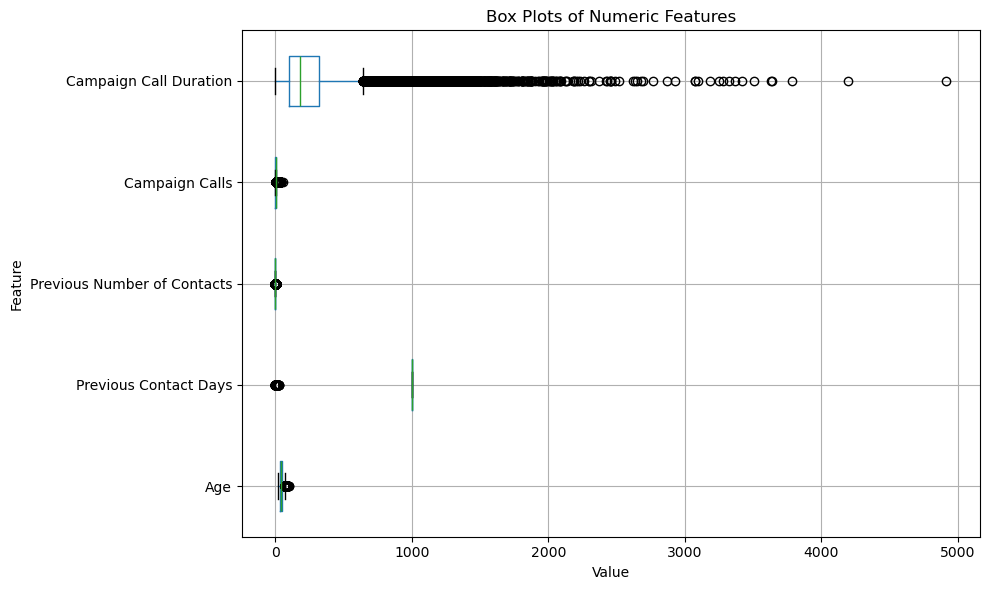

In [139]:
# Cell 3
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include="number").columns.tolist()

if not num_cols:
    print("No numeric columns to plot.")
else:
    plt.figure(figsize=(10, 6))
    df[num_cols].boxplot(vert=False)
    plt.title("Box Plots of Numeric Features")
    plt.xlabel("Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


In [140]:
import numpy as np
import pandas as pd

col = "Campaign Call Duration"

# 1) Clean
df[col] = pd.to_numeric(df[col], errors="coerce")          # force numeric
df[col] = df[col].abs()                                    # flip negatives
median_val = df[col].median()
df[col] = df[col].fillna(median_val)                       # impute NaN
# (optional) also replace zeros if you consider them invalid
# df.loc[df[col] == 0, col] = median_val

# Sanity check
print("Negatives left:", (df[col] < 0).sum())

# 2) Bin into 10 equal-width bins starting at 0
edges = np.linspace(0, df[col].max(), 11)                  # 10 bins => 11 edges
df[f"{col}_bin"] = pd.cut(df[col], bins=edges, include_lowest=True)
df[f"{col}_bin_id"] = pd.cut(df[col], bins=edges,
                             labels=range(10), include_lowest=True)

print(edges)
df[[col, f"{col}_bin", f"{col}_bin_id"]].head()


Negatives left: 0
[   0.   491.8  983.6 1475.4 1967.2 2459.  2950.8 3442.6 3934.4 4426.2
 4918. ]


,Campaign Call Duration,Campaign Call Duration_bin,Campaign Call Duration_bin_id
0,261,"(-0.001, 491.8]",0
1,149,"(-0.001, 491.8]",0
2,226,"(-0.001, 491.8]",0
3,151,"(-0.001, 491.8]",0
4,307,"(-0.001, 491.8]",0


In [141]:
col = "Campaign Call Duration"
n_bins = 10

# clean
s = pd.to_numeric(df[col], errors="coerce").abs()
s = s.fillna(s.median())
df[col] = s  # single, explicit assignment

# bin
edges = np.linspace(0, df[col].max(), n_bins + 1)
edges[0] = 0.0
df[f"{col}_bin"]    = pd.cut(df[col], bins=edges, include_lowest=True)
df[f"{col}_bin_id"] = pd.cut(df[col], bins=edges, labels=range(n_bins), include_lowest=True)



In [142]:
print("Any negatives left?", (df[col] < 0).any())
print("Bin edges:", edges)


Any negatives left? False
Bin edges: [   0.   491.8  983.6 1475.4 1967.2 2459.  2950.8 3442.6 3934.4 4426.2
 4918. ]


In [143]:
print(edges)
print(df[[col, f"{col}_bin", f"{col}_bin_id"]].head())

[   0.   491.8  983.6 1475.4 1967.2 2459.  2950.8 3442.6 3934.4 4426.2
 4918. ]
   Campaign Call Duration Campaign Call Duration_bin  \
0                     261            (-0.001, 491.8]   
1                     149            (-0.001, 491.8]   
2                     226            (-0.001, 491.8]   
3                     151            (-0.001, 491.8]   
4                     307            (-0.001, 491.8]   

  Campaign Call Duration_bin_id  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0  
